# ✨ K-Nearest Neighbors Classification with LSH

In this notebook, we explore K-Nearest Neighbors classification with:

- **Synthetic data** generated with Gaussian noise
- Implementing a **weighted k-NN with Gaussian kernel**
  
Evaluation metrics and visualizations are included for comparison.

In [22]:
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.random import Generator
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

## 🛠️ Utils

In [23]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [24]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
    subtitle: str = "Clustering Overview",
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
        subtitle (str): Title for the entire plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(subtitle)

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()

## 📊 Generate Dataset

In [25]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=10000, num_clusters=4, space_size=50, noise_level=7, dim=2, seed=412
)

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚖️ Weighted k-nearest neighbors with LSH

In [27]:
class EuclideanLSH:
    """Locality-Sensitive Hashing (LSH) for approximate nearest neighbor search.

    Attributes:
        num_hashes (int): Number of hash functions (i.e., hyperplanes).
        dim (int): Dimensionality of the input data.
        r (int): Width of each hash bin.
        w (NDArray[np.float64]): Random projection vectors (shape: [num_hashes, dim]).
        b (NDArray[np.float64]): Random biases (shape: [num_hashes]).
        buckets (dict[tuple, list[int]]): Hash table mapping hash keys to list of indices.
        data (NDArray[np.float64] | None): Data matrix after calling `fit()`.
    """

    def __init__(self, num_hashes: int, dim: int, r: int, seed: int | None = 42) -> None:
        """Initialize the LSH structure.

        Args:
            num_hashes (int): Number of hash functions.
            dim (int): Dimensionality of the input data.
            r (int): Bucket width (affects quantization of projections).
            seed (int | None): Random seed for reproducibility (default: 42).
        """
        self.num_hashes: int = num_hashes
        self.dim: int = dim
        self.r: int = r
        self.buckets: dict[tuple, list] = defaultdict(list)
        self.data: NDArray[np.float64] | None = None
        
        if seed is not None:
            np.random.seed(seed)

        self.w = np.random.randn(num_hashes, dim)
        self.b = np.random.uniform(0, r, size=num_hashes)

    def _hash(self, x: NDArray[np.float64]) -> NDArray[np.int64]:
        """Compute the LSH hash code for a single vector.

        Args:
            x (NDArray[np.float64]): Input vector of shape (dim,).

        Returns:
            NDArray[np.int64]: Hash code of shape (num_hashes,).
        """
        projections = np.dot(self.w, x) + self.b
        return np.floor(projections / self.r).astype(int)
    
    def _hash_batch(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Compute LSH hash codes for a batch of vectors.

        Args:
            X (NDArray[np.float64]): Data matrix of shape (n_samples, dim).

        Returns:
            NDArray[np.int64]: Hash codes of shape (n_samples, num_hashes).
        """
        projections = np.dot(X, self.w.T) + self.b
        return np.floor(projections / self.r).astype(int)
    
    def fit(self, X: NDArray[np.float64]) -> None:
        """Index the dataset by hashing each data point into buckets.

        Args:
            X (NDArray[np.float64]): Data matrix of shape (n_samples, dim).
        """
        self.data = X
        hashes = self._hash_batch(X)
        
        for idx, h in enumerate(hashes):
            key = tuple(h)
            self.buckets[key].append(idx)

    def query(self, x: NDArray[np.float64], top_k: int, search_radius: int = 1) -> list[int]:
        """Query the LSH index for approximate nearest neighbors.

        Args:
            x (NDArray[np.float64]): Query point of shape (dim,).
            top_k (int): Number of approximate nearest neighbors to return.
            search_radius (int): Number of hash bucket offsets to search 
                if the initial bucket is empty (default: 1).

        Returns:
            list[int]: List of indices of the top-k approximate nearest neighbors 
                in the original dataset.
        """
        q_hash = self._hash(x)
        key = tuple(q_hash)
        candidates_idx = self.buckets.get(key, [])

        if not candidates_idx:
            candidates_idx = []
            offsets = list(product(range(-search_radius, search_radius+1), repeat=len(q_hash)))
            for offset in offsets:
                neighbor_key = tuple(h + o for h, o in zip(q_hash, offset))
                candidates_idx.extend(self.buckets.get(neighbor_key, []))
        
        if not candidates_idx:
            return []

        candidates = self.data[candidates_idx]
        dists = np.linalg.norm(candidates - x, axis=1)
        nearest = np.argsort(dists)[:top_k]

        return [candidates_idx[i] for i in nearest]

In [28]:
def gaussian_kernel(t: NDArray[np.float64] | float) -> NDArray[np.float64] | float:
    """Gaussian (normal) kernel function.

    Args:
        t (NDArray[np.float64] | float): Input value(s).

    Returns:
        NDArray[np.float64] | float: Kernel-weighted value(s).
    """
    return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)


def weighted_knn_kernel(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    X_test: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
    h: float = 1.0,
) -> NDArray[np.float64]:
    """Predict labels using weighted k-NN with a Gaussian kernel and LSH.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        X_test (NDArray[np.float64]): Test features, shape (n_test_samples, n_features).
        k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
        p (float, optional): Order of the Minkowski distance. Defaults to 2.0.
        h (float, optional): Bandwidth parameter for the Gaussian kernel. Defaults to 1.

    Returns:
        NDArray[np.float64]: Predicted labels for each sample in X_test.
    """
    lsh = EuclideanLSH(num_hashes=10, dim=X_train.shape[1], r=7.5)
    lsh.fit(X_train)

    y_predicted: list[float] = []

    for x_new in tqdm(X_test):
        neighbor_idx = lsh.query(x_new, k_neighbors)

        neighbors = X_train[neighbor_idx]
        neighbor_distances = np.linalg.norm(neighbors - x_new, axis=1)
        neighbor_labels = y_train[neighbor_idx]

        weights = gaussian_kernel(neighbor_distances / h)

        class_weights = {}
        for label, weight in zip(neighbor_labels, weights, strict=False):
            class_weights[label] = class_weights.get(label, 0) + weight

        predicted_label = max(class_weights, key=class_weights.get)
        y_predicted.append(predicted_label)

    return np.array(y_predicted)


# Predict labels for all samples in X_test
predicted = weighted_knn_kernel(X_train, y_train, X_test, k_neighbors=5, p=5, h=5.8)

  0%|          | 0/8000 [00:00<?, ?it/s]

Accuracy:  0.9161
Precision: 0.9164
Recall:    0.9161
F1 Score:  0.9162


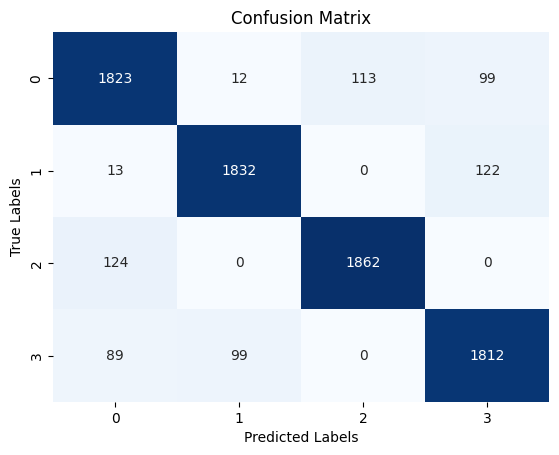

In [29]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

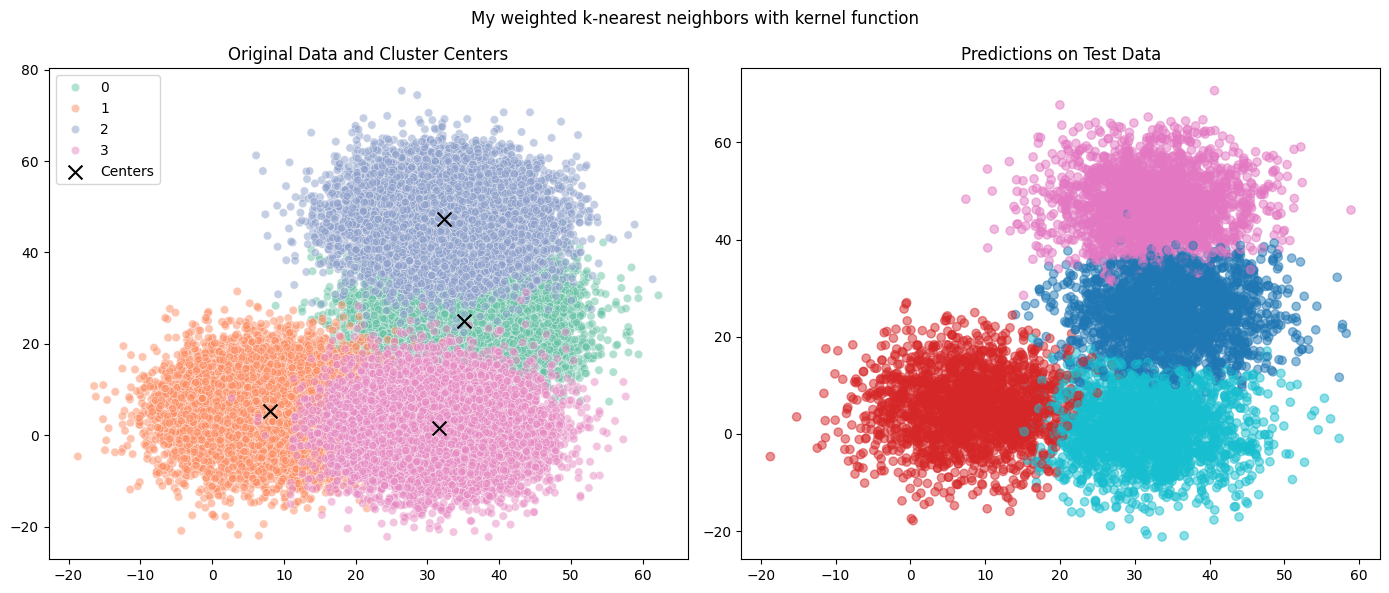

In [30]:
plot_clusters(
    data,
    centers,
    X_test,
    predicted,
    labels,
    "My weighted k-nearest neighbors with kernel function",
)